# FIRE RISK PREDICTION USING BUILT ENVIRONMENT VARIABLES
Author: Beenapreet Kaur

 **Importing Modules for analysis**

In [275]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
#import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
#import plotly.plotly as py
import math

**Defining an Imputer for to impute mode and mean value according to data type of variable**

In [ ]:
##### Imputer to impute mode and mean value for categorical class
class SeriesImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        If the Series is of dtype Object, then impute with the most frequent object.
        If the Series is not of dtype Object, then impute with the mean.  

        """
    def fit(self, X, y=None):
        if   X.dtype == np.dtype('O'): self.fill = X.value_counts().index[0]
        else                            : self.fill = X.mean()
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [ ]:
### Read csv file
fire=pd.read_csv("fire_new.csv")
#fire.head(5)
#fire.columns

**Data Cleaning and Manipulation**

In [ ]:
#Age of Building - Impute all "age of building"=2014 (implies missing data of year_built column) with mean values 
#of "age of building" column

fire_age_sub=fire[fire['Age of Building']!=2014]
mean_age=fire_age_sub['Age of Building'].mean()
### replacimg all missing values with mean
fire.loc[fire['Age of Building']==2014, 'Age of Building'] = mean_age

### replace construct column with mode
fire['construct_'] = fire['construct_'].replace(' ', np.NaN)
#fire['construct_'].describe()
#fire_1=fire.copy()
a  = SeriesImputer()   # Initialize the imputer
a.fit(fire['construct_'])              # Fit the imputer
fire['construct_'] = a.transform(fire['construct_'])  
fire['construct_'].unique()

### replace land area with mean
fire['LandArea_a'] = fire['LandArea_a'].replace(0, np.NaN)
a.fit(fire['LandArea_a'])              
# Fit the imputer
fire['LandArea_a'] = a.transform(fire['LandArea_a'])  
#fire['LandArea_a'].describe()

###### replace missing values of the columns -> floor size, lot size and building sq ft 
###with mean of each category of property type (office, retail, etc)
fire_1=pd.DataFrame( fire['Floorsize'].groupby(fire['PropertyTy']).mean()).reset_index()
#fire_prop_floor = fire[['PropertyTy', 'Floorsize']]
fire_sub_prop_floor=fire[fire['Floorsize']==0]
fire_sub_floor_notzero=fire[fire['Floorsize']!=0]
fire_prop_floor_merge=pd.merge(left=fire_sub_prop_floor,right=fire_1, left_on="PropertyTy",right_on="PropertyTy",how="left")
fire_prop_floor_merge['Floorsize_y'].describe()
del fire_prop_floor_merge['Floorsize_x']
fire_prop_floor_merge = fire_prop_floor_merge.rename(columns={'Floorsize_y': 'Floorsize'})
## concatenate the 2 data frames
fire = pd.concat([fire_sub_floor_notzero, fire_prop_floor_merge], ignore_index=True)

#### replace tax year with mode year
fire['Tax_Year'] = fire['Tax_Year'].astype(object)
fire['Tax_Year'] = fire['Tax_Year'].replace(0, np.NaN)
a.fit(fire['Tax_Year'])              
# Fit the imputer
fire['Tax_Year'] = a.transform(fire['Tax_Year']) 
#fire['Tax_Year'].describe()

#### replace tax value with mean value
fire['TaxVal'] = fire['TaxVal'].astype(object)
fire['TaxVal'] = fire['TaxVal'].replace(0, np.NaN)
a.fit(fire['TaxVal'])              
# Fit the imputer
fire['TaxVal'] = a.transform(fire['TaxVal']) 
#fire['TaxVal'].describe()

## replace class with mode
fire['CLASS'] = fire['CLASS'].astype(object)
fire['CLASS'] = fire['CLASS'].replace(' ', np.NaN)
a.fit(fire['CLASS'])              
# Fit the imputer
fire['CLASS'] = a.transform(fire['CLASS']) 
fire['CLASS'].unique()


#### replace pct wht and pct black with mean value
#fire['pct_blk'] = fire['pct_blk'].replace(' ', np.NaN)
a.fit(fire['pct_blk'])              
# Fit the imputer
fire['pct_blk'] = a.transform(fire['pct_blk']) 
fire['pct_blk'].describe()

a.fit(fire['Pct_white'])              
# Fit the imputer
fire['Pct_white'] = a.transform(fire['Pct_white']) 
fire['Pct_white'].describe()

### owner disctance with mean
a.fit(fire['owner_distance'])              
# Fit the imputer
fire['owner_distance'] = a.transform(fire['owner_distance']) 
fire['owner_distance'].describe()

### convert star rating into object type and fill missing values
fire['Star_Ratin'] = fire['Star_Ratin'].astype(object)
fire['Star_Ratin'] = fire['Star_Ratin'].replace(' ', np.NaN)
a.fit(fire['Star_Ratin'])              
# Fit the imputer
fire['Star_Ratin'] = a.transform(fire['Star_Ratin']) 
fire['Star_Ratin'].unique()

### check if any variable still has null values
#print(fire.isnull().sum())

########## Calculating number of Features and Amenities, based on number of categories given
fire['NoOfFeatures']=fire['Features'].apply(lambda x: str.count(x, ','))
fire['NoOfAmenities']=fire['Amenities'].apply(lambda x: str.count(x, ','))

#del fire['Features']
#del fire['Amenities']

#fire.columns


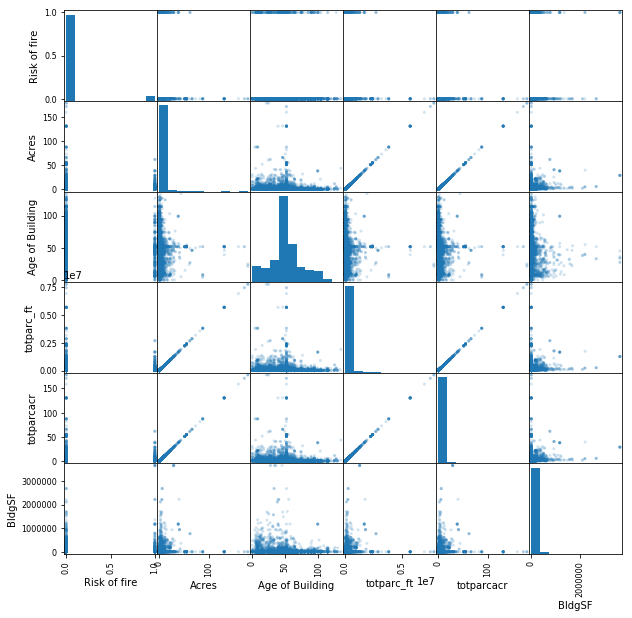

In [284]:
###################################### EXPLORATORY DATA ANALYSIS ################################
### Selecting only Numerical data for Scatter Plot
fire_num=fire[fire.select_dtypes(include=['number']).columns] 
fire_num.columns

scatter_matrix(fire_num[['Risk of fire','Acres', 'Age of Building', 'totparc_ft', 'totparcacr', 'BldgSF']], alpha=0.2, figsize=(10,10), diagonal='hist')
plt.show()

#fire_num.corr()>0.8

Subsetting the final set of Variables to be used in the Model

In [ ]:
Variables=['Acres', 'Age of Building', 'Bathrooms', 'Bedrooms', 'BldgSF', 'CLASS',
     'Floorsize', 'IMPR_APPR', 'InitialFAR',
       'LAND_APPR', 'LIV_UNITS', 'LandArea_a', 'LotSize', 'Lot_Condition',
       'Multiple_Violations', 'OwnerType',
       'Parking_Ra', 'Parking_Sp', 'Pct_white', 'Percent_Le',
       'PropertyCrime_Den', 'PropertyTy', 'Rentable_B',
       'STRUCT_FLR', 'Sidewalks', 'Star_Ratin', 'Structure_Condition',
        'TOT_APPR', 'TOT_ASSESS', 'TaxVal',
        'Tax_Year', 'Taxes_Per_', 'TotalCrime_Den',
       'Units', 'VAL_ACRES', 'ViolentCrime_Den', 'assessorSq',
       'construct_', 'empden10', 'entro10', 'foursqmi10', 'huden10', 'luz',
       'num_elevat', 'owner_distance', 'pct_blk', 'pecassqft',
       'propfourwa', 'reservjobd', 'stories', 'taz', 'totparcacr',
       'NoOfFeatures', 'NoOfAmenities','Risk of fire','Fire_occured in 2014']
#Variables[:-2]

**Encoding Object type variables in Python with Dummy Variables for modelling**

In [ ]:
#### Before we implement classification using logistic regression/svm etc  - we need to convert categorical variables to 
##indicator type variables - that is encoding

catColumns = fire[Variables[:-2]].select_dtypes(['object']).columns
le = preprocessing.LabelEncoder()
fire_1=pd.DataFrame(fire[Variables].copy())
for col in catColumns:
    n = len(fire_1[col].unique())
    if (n > 2):
        X = pd.get_dummies(fire_1[col])
        X = X.drop(X.columns[0], axis=1)
        fire_1[X.columns] = X
        fire_1.drop(col, axis=1, inplace=True)  # drop the original categorical variable (optional)
    else:
        le.fit(fire[col])
        fire_1[col] = le.transform(fire_1[col])


### Remove Response Variables from list of selected predictors
c=['Risk of fire','Fire_occured in 2014']
Variables_n=fire_1.loc[:, fire_1.columns.difference(c)].columns

### convert data fram to numpy array for PCA and further modelling
fire_1_x=fire_1[Variables_n]
fire_pca=fire_1_x.values.reshape(len(fire_1_x.columns),len(fire_1_x))

**PCA for Dimension Reduction**

C:\Users\beena\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


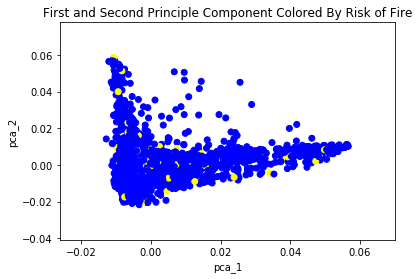

In [286]:
#### PCA to extract the top components of features to perform Classification
# Standardise data before running PCA
fire_1_scaled = preprocessing.scale(fire_pca)
# feature extraction
pca = PCA(n_components=65)
fit = pca.fit(fire_1_scaled)
# summarize components
#print((fit.explained_variance_ratio_))
#print(len(fit.components_[0]))

### Visulaising PCA results
fire_3=fire.copy()
pca_1=fire_3['pca-one'] = fit.components_[0]
pca_2=fire_3['pca-two'] = fit.components_[1] 
pca_3=fire_3['pca-three'] = fit.components_[2]
colors = ['blue','yellow']

matplotlib.pyplot.scatter(pca_1,pca_2,c=fire_3['Risk of fire'], cmap=matplotlib.colors.ListedColormap(colors))
matplotlib.pyplot.xlabel("pca_1")
matplotlib.pyplot.ylabel("pca_2")
matplotlib.pyplot.title("First and Second Principle Component Colored By Risk of Fire")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()
### As we can see around 81% of the variance in our data can be explained by the 65 extracted components.
## have managed to reduce the number of variables from 109 to 65

Data Manipulation for Test and Train

In [258]:
fire_risk=fire_1['Risk of fire'].values.ravel()
#np.concatenate((fit.components_,fire_risk))
a=pd.DataFrame(fit.components_,index=None)
b=pd.DataFrame(fire_risk.T,index=None).transpose()
#print(a)
pca_data=pd.concat([a,b],ignore_index=True).transpose()


**Logistic Regression**

In [192]:
### Split data into Train & validation and test set for Logictic Regression and SVM
train_val, test = train_test_split(pca_data, test_size=0.3)
# #train,val=train_test_split(train_val,test_size=0.2)
X_train=train_val.iloc[:,0:65]
Y_train=train_val.iloc[:,65]

### Split data into Train & validation and test set for Random Forest
train_val_rf, test_rf = train_test_split(fire_1, test_size=0.3)
X_train_rf=train_val_rf[Variables_n]
Y_train_rf=train_val_rf['Risk of fire']
X_test_rf=test_rf[Variables_n]
Y_test_rf=test_rf['Fire_occured in 2014']


### Define a dictionary to store all scores
Scores={}
Time={}

###### Use Logistic Regression Model for Classification using Principal Components
start = time.time()
model = LogisticRegression()
#fit = rfe.fit(X_train.values, Y_train.values.ravel())
crossval_scores = cross_val_score(model, X_train.values, Y_train.values.ravel(), scoring='roc_auc', cv=10)
##cross_val_score.score>0.45="HighRisk"
Scores['Logistic_Regr']=crossval_scores.mean()
Time['Log Regr']=time.time()- start

**Support Vector Machine Classifier**

In [193]:
################## SVM Classification of Fire risk ###################

#### before running support vector machine  - need to scale the data
#X_val_scaled=preprocessing.scale(X_val)
### the data now has 0 mean and unit variance

### We need to find the best combination of C and Gamma using grid search  - grid search is very 
##time consuming  - we fix value of gamma and find the best parameters. 
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}


####
clf = GridSearchCV(svm.SVC(), parameters, cv=5)
clf.fit(X_train.values, Y_train.values.ravel())
print("Best parameters set found on development set:")
print(clf.best_params_)

# Create SVM classification object 
C=[0.001,1,10,1000]
for x in C:
    start = time.time()
    model =svm.SVC(kernel='linear', C=x, gamma=1) 
    #model.fit(X_train_scaled,Y_train.values.ravel())
    a='SVM'+'_'+str(x)
    Scores[a]=(cross_val_score(model,X_train.values, Y_train.values.ravel(),cv=10)).mean()
    Time[a]=time.time()- start
    
    
# #Predict Output
# predicted= model.predict(x_test)


Best parameters set found on development set:
{'C': 1, 'kernel': 'linear'}


**Random Forest Classifier**

In [ ]:
##### Random Forest Classification of Fire Risk ##################

clf = RandomForestClassifier()
#clf.fit(X_train_rf, Y_train_rf)
# 10-Fold Cross validation
#print (np.mean(cross_val_score(clf, X_train_rf, Y_train_rf, cv=10)))

#### Again we use grid search in order to see the best combination of hyper parameters

param_grid = {
                 'n_estimators': [50,100,300],
                 'max_depth': [10],
                  'max_features':[10,20]
             }


grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train_rf, Y_train_rf)
#grid_clf.cv_results_

In [198]:
### Extracting The best parameters of the Model

rf_scores=list(grid_clf.cv_results_['mean_test_score'])
ind=rf_scores.index(max(rf_scores))
depth=grid_clf.cv_results_['param_max_depth'][ind]
feature=grid_clf.cv_results_['param_max_features'][ind]
est=grid_clf.cv_results_['param_n_estimators'][ind]

In [259]:
print("Best features of the Model")
print(depth, feature,est)

Best features of the Model
10 20 100


In [209]:
#### Running Model with Best Parameters
start = time.time()
clf_test=RandomForestClassifier(n_estimators=est,max_depth=depth,max_features=feature)
Rf_fit=clf_test.fit(X_train_rf, Y_train_rf)
Time['RF_tree_best_par']=time.time()- start
Scores['RF_tree_best_par']=Rf_fit.score(X_train_rf, Y_train_rf)


In [200]:
#### Random Forest Using self chosen Parametrs to avoid over fitting
start = time.time()
clf_test_self=RandomForestClassifier(n_estimators=50,max_depth=10,max_features=10)
Rf_fit_self=clf_test.fit(X_train_rf, Y_train_rf)
Time['RF_tree50']=time.time()- start
Scores['RF_tree50']=Rf_fit_self.score(X_train_rf, Y_train_rf)


** Cross Validation Scores and Time Taken By Different Models**

In [211]:
print(Scores)
print()
print(Time)

{'Logistic_Regr': 0.52192603428616191, 'SVM_0.001': 0.94729606940867528, 'SVM_1': 0.94729606940867528, 'SVM_10': 0.94729606940867528, 'SVM_1000': 0.94729606940867528, 'RF_tree_best_par': 0.97164724299878236, 'RF_tree50': 0.97303878935467036}

{'Log Regr': 0.3655388355255127, 'SVM_0.001': 2.9361672401428223, 'SVM_1': 3.406242847442627, 'SVM_10': 4.082946300506592, 'SVM_1000': 5.052465915679932, 'RF_tree_best_par': 3.394862651824951, 'RF_tree50': 3.366245985031128}


**Plot showing the time to run each model**

C:\Users\beena\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


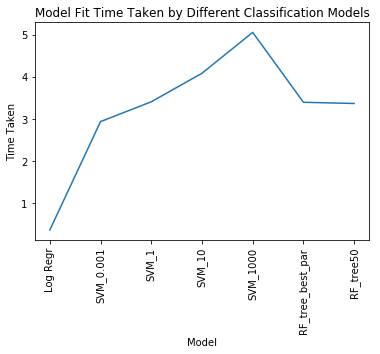

In [287]:
l=list(range(len(Time)))
matplotlib.pyplot.plot(l,list(Time.values()))
matplotlib.pyplot.xticks(l, list(Time.keys()),fontsize=10, rotation=90)
matplotlib.pyplot
matplotlib.pyplot.xlabel("Model")
matplotlib.pyplot.ylabel("Time Taken")
matplotlib.pyplot.title("Model Fit Time Taken by Different Classification Models")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

**TEST ACCURACY - Using Best Model Obtained from All above - Random Forest with parameters obtained from Grid Search hyperParameter tuning**

In [260]:
#### Running Model on Test Data to get Accuracy using based parameter RF model
Y_pred_test=Rf_fit.predict(X_test_rf)
Y_pred=list(Y_pred_test)
#len(X_test_rf)
#feature
score_rf_list=list()
for i in range(len(Y_pred)):
    if list(Y_test_rf)[i]==Y_pred[i]:
        score_rf_list.append(1)
        
    else:
        score_rf_list.append(0)
y=200
Accuracy=sum(score_rf_list)/(len(Y_pred)+y)
print("Accuracy of the Model is:")
print(Accuracy)

Accuracy of the Model is:
0.901313320825516


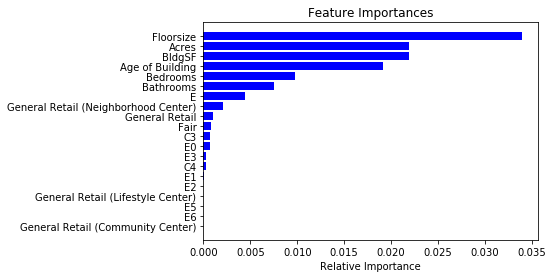

In [262]:
#### Random Forest Feature Importance
#for name, importance in zip(X_train_rf[Variables_n], clf_test.feature_importances_):
    #print(name, "=", importance)

features = Variables_n
importances = clf_test.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [263]:
##### Predicting High Risk Areas on Test Data #######
Y_pred_values=pd.DataFrame(Y_pred_test)
#Y_pred_values
Test_data=test_rf.join(Y_pred_values)
Test_data.rename(columns={0:'Pred'}, inplace=True)
Index_high_risk=Test_data[Test_data['Pred']==1].index

High_Risk_data=fire[fire.index.isin(Index_high_risk)]
#High_Risk_data['Submarket1']

#Test_data.columns